# Keyword Spotting Model Training

Training a keyword spotting model on a command dataset made by Google.

### Steps:
1. **Setup**
2. **Audio Preprocessing**
3. **Model Definition**
4. **Training**
5. **Evaluation**
6. **Quantization for Deployment**


**1. Setup**

Install and import used libraries.

In [81]:
%%capture
%pip install tensorflow matplotlib scikit-learn tensorflow-datasets tfds-nightly seaborn pydub

In [82]:
import os
import glob
import random
import shutil
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import soundfile as sf
from collections import defaultdict
from pydub import AudioSegment
from pydub.effects import speedup, normalize


General constants used in the process

In [83]:
TEST_DATASET_SIZE = 0.1
VALIDATION_DATASET_SIZE = 0.1
EPOCHS = 20
LEARNING_RATE = 0.005
BATCH_SIZE = 32

SAMPLE_RATE = 16000
WINDOW_SIZE = 512
STEP_SIZE = 384
LOWER_BAND_LIMIT = 80.0
UPPER_BAND_LIMIT = 7600.0

NUMBER_OF_MEL_BINS = 40
NUMBER_OF_MFCCS = 13

wanted_commands = ["yes", "no"]

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.15.0


Download the dataset

In [84]:
DATASET_PATH = 'dataset-speech'
data_directory = pathlib.Path(DATASET_PATH)

if not data_directory.exists():
    tf.keras.utils.get_file('speech_commands_v0.01.tar.gz',
                            'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                            cache_dir='./',
                            cache_subdir='dataset-speech',
                            extract=True)
    
print("Data directory: ", data_directory)

Data directory:  dataset-speech


Backgroung noise audio files are longer than 1 second. To be able to include then in training they must be split into 1s fragments.

In [85]:
files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
print(files)

background_dir = f'./{DATASET_PATH}/background'
print(background_dir)
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print('Splitting', filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  print("Sample rate: ", rate)
  length = round(librosa.get_duration(path=file))
  print("Length: ", length)
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

['./dataset-speech/_background_noise_\\doing_the_dishes.wav', './dataset-speech/_background_noise_\\dude_miaowing.wav', './dataset-speech/_background_noise_\\exercise_bike.wav', './dataset-speech/_background_noise_\\pink_noise.wav', './dataset-speech/_background_noise_\\running_tap.wav', './dataset-speech/_background_noise_\\white_noise.wav']
./dataset-speech/background
Splitting doing_the_dishes.wav
Sample rate:  16000
Length:  95
Splitting dude_miaowing.wav
Sample rate:  16000
Length:  62
Splitting exercise_bike.wav
Sample rate:  16000
Length:  61
Splitting pink_noise.wav
Sample rate:  16000
Length:  60
Splitting running_tap.wav
Sample rate:  16000
Length:  61
Splitting white_noise.wav
Sample rate:  16000
Length:  60


Up until this point all we have is a dataset of spoken words and background noise. The next step is to prepare the dataset for learning. We must decide which subset od spoken words we want to train on (be able to recognize) and build a dataset of 'unknown' category which will be made of a subset of the rest of the dataset. Wanted words list is defined in the beggining of the notebook.

In [86]:
def augment_audio(audio: AudioSegment) -> AudioSegment:
    # Start with the original audio
    augmented = audio

    # Randomly apply speed adjustments (time stretching)
    if random.random() > 0.5:
        augmented = speedup(augmented, playback_speed=random.uniform(1.1, 1.5))

   
    # Normalize volume to ensure consistent loudness
    augmented = normalize(augmented)

    # Add random volume adjustments (increase or decrease volume)
    if random.random() > 0.5:
        volume_change = random.uniform(-5, 5)  # Random volume change in dB
        augmented = augmented + volume_change

    # Add echo (simulated by overlapping the original with a delayed copy)
    if random.random() > 0.5:
        delay_ms = random.randint(100, 500)  # Random delay in milliseconds
        echo = augmented - random.uniform(5, 10)  # Lower volume for the echo
        augmented = augmented.overlay(echo, position=delay_ms)

    # Optionally, you could reverse the audio for more variation
    if random.random() > 0.5:
        augmented = augmented.reverse()

    return augmented

In [87]:
print("Wanted commands: ", wanted_commands)

commands_dataset = './commands'

# Create a list to store paths for the "unknown" set
unknown_candidates = []

# Check if the commands_dataset already exists
if not os.path.exists(commands_dataset):
    print(f"{commands_dataset} does not exist. Starting the copying process.")
    os.makedirs(commands_dataset, exist_ok=True)

    # Iterate through folders in the dataset
    for folder_name in os.listdir(DATASET_PATH):
        source_path = os.path.join(DATASET_PATH, folder_name)
        destination_path = os.path.join(commands_dataset, folder_name)

        # Check if it's a folder and if it's in the wanted commands list or if it's 'background'
        if os.path.isdir(source_path) and (folder_name in wanted_commands or folder_name == 'background'):
            # Copy the folder to the commands_dataset
            shutil.copytree(source_path, destination_path, dirs_exist_ok=True)  # Allows overwriting if needed
            print(f"Copied: {folder_name} -> {destination_path}")
        else:
            #print(f"Skipped: {folder_name}")
            # Collect files for the unknown set
            if os.path.isdir(source_path) and folder_name != '_background_noise_' and folder_name != '.DS_Store':
                unknown_candidates.extend(
                    [os.path.join(source_path, file) for file in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, file))]
                )
else:
    print(f"{commands_dataset} already exists. Skipping copying process.")


# Track folder sizes
folder_sizes = defaultdict(int)
for folder_name in os.listdir(commands_dataset):
    source_path = os.path.join(commands_dataset, folder_name)
    folder_sizes[folder_name] = len(os.listdir(source_path))

filtered_sizes = {key: folder_sizes[key] for key in wanted_commands}
target_size_background =  round(sum(filtered_sizes.values()) / len(filtered_sizes))
target_size_unknown = round(sum(filtered_sizes.values()) / len(filtered_sizes))

# augment background
print("Augmenting background..")
background_path = os.path.join(commands_dataset, 'background')
# Load the background noise files
background_files = [f for f in os.listdir(background_path) if f.endswith('.wav')]
current_file_count = len(background_files)
#print(current_file_count)
new_files_count = 0
while new_files_count < target_size_background - current_file_count:
    original_file = random.choice(background_files)
    original_audio = AudioSegment.from_wav(os.path.join(background_path, original_file))
    # Apply augmentations
    augmented_audio = augment_audio(original_audio)
    # Export the augmented audio to a new file
    new_file_name = f"augmented_{new_files_count + current_file_count}.wav"
    augmented_audio.export(os.path.join(background_path, new_file_name), format="wav")
    new_files_count += 1
    #print(f"Augmented and saved: {new_file_name}")
print(f"Finished creating {target_size_background} background noise files in the folder.")

# make 'unknown' category with mix of the rest of the dataset
print("Making 'unknown' category")
unknown_folder = 'unknown'
unknown_path = os.path.join(commands_dataset, unknown_folder)

if not os.path.exists(unknown_path):
    os.makedirs(unknown_path, exist_ok=True)

    # Randomly sample files for the unknown set
    print(unknown_candidates)
    unknown_files = random.sample(unknown_candidates, target_size_unknown)

    copied_files_count = 0

    for file in unknown_files:
        base_name = os.path.basename(file)
        file_name, file_extension = os.path.splitext(base_name)

        # Create a new filename by appending a counter
        new_filename = f"{file_name}_{copied_files_count}{file_extension}"
        copied_files_count += 1

        shutil.copy(file, os.path.join(unknown_path, new_filename))
    print(f"Created 'unknown' set with {target_size_unknown} files.")
else:
    print(f"'unknown' set already exists. Skipping creation.")


for folder_name in os.listdir(commands_dataset):
    source_path = os.path.join(commands_dataset, folder_name)
    folder_sizes[folder_name] = len(os.listdir(source_path))

print(folder_sizes)


Wanted commands:  ['yes', 'no']
./commands already exists. Skipping copying process.
Augmenting background..
Finished creating 3992 background noise files in the folder.
Making 'unknown' category
'unknown' set already exists. Skipping creation.
defaultdict(<class 'int'>, {'background': 3992, 'no': 3941, 'unknown': 3992, 'yes': 4044})


Print available commands

In [88]:
print(folder_sizes)

defaultdict(<class 'int'>, {'background': 3992, 'no': 3941, 'unknown': 3992, 'yes': 4044})


In [89]:
commands = np.array(tf.io.gfile.listdir(str(commands_dataset)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['background' 'no' 'unknown' 'yes']


The audio clips are about 1 second long sampled at 16 kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second and trims longer ones so that they can be easily batched.

This function only lets us split the validation dataset from all of the available data. It is later split into test and validation data separately. Because of this, validation_split parameter is set to TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE.

In [90]:
train_dataset, validation_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=commands_dataset,
    batch_size=BATCH_SIZE,
    validation_split=TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_dataset.class_names)
print("\nLabel names:", label_names)
print("\nDataset type: ", train_dataset.element_spec)

Found 15969 files belonging to 4 classes.
Using 12776 files for training.
Using 3193 files for validation.

Label names: ['background' 'no' 'unknown' 'yes']

Dataset type:  (TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels). This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis.

In [91]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(squeeze, tf.data.AUTOTUNE)

print("Dataset type: ", train_dataset.element_spec)


Dataset type:  (TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Split validation set into two smaller datasets => one for testing and one for validation.

In [92]:
test_dataset = validation_dataset.shard(num_shards=2, index=0)
validation_dataset = validation_dataset.shard(num_shards=2, index=1)

Check shape of an example audio data

In [93]:
for example_audio, example_labels in train_dataset.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 16000)
(32,)


Plot a few audio waveforms

In [94]:
def printShape(dataset):
    for data, label in dataset.take(1):
        print("Shape: ", data.shape)
    return data.shape


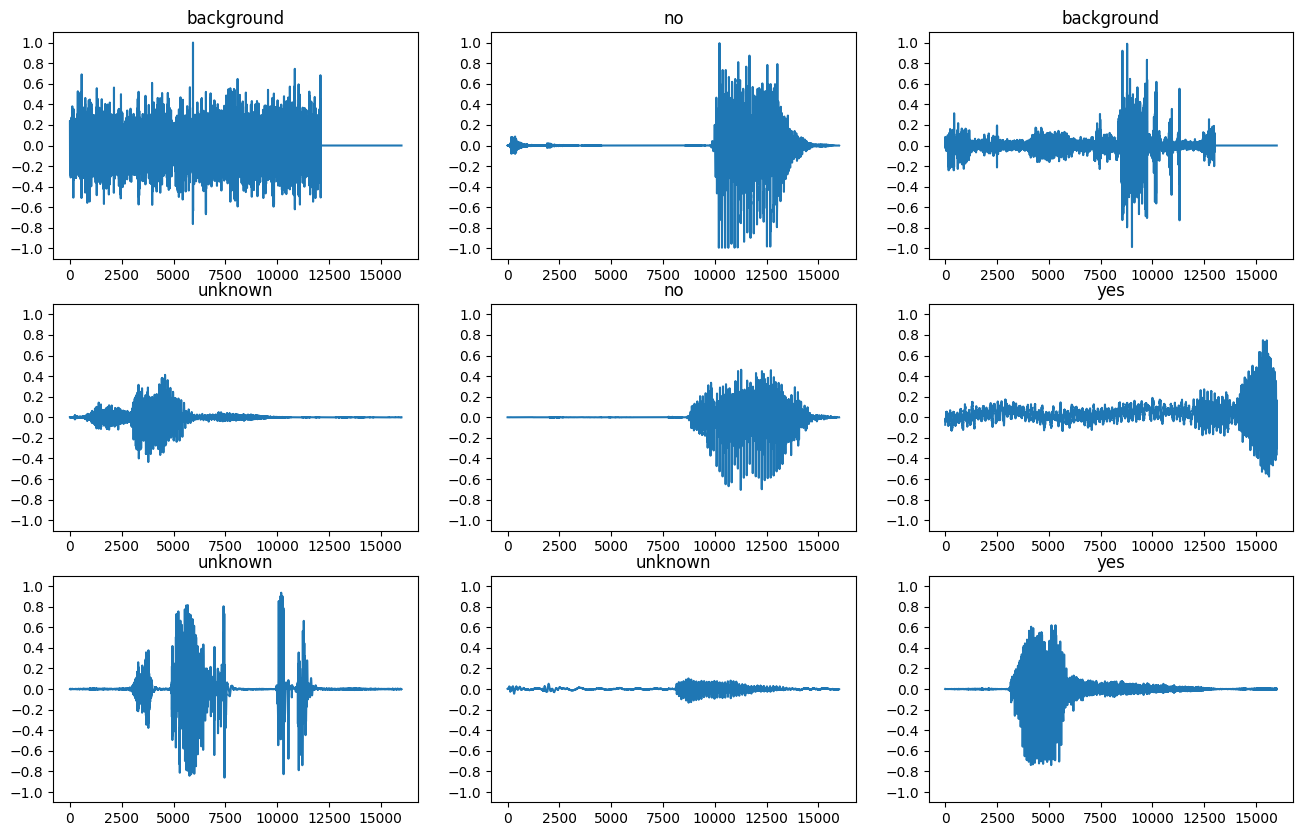

In [95]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

2. **Audio Preprocessing**

Function that generates MFCCs from a given audio sample.

In [96]:
def generate_mfccs(audio):

  # Compute the spectrogram
  stft = tf.signal.stft(
    audio,
    frame_length=WINDOW_SIZE,
    frame_step=STEP_SIZE,
    fft_length=WINDOW_SIZE,
    window_fn=tf.signal.hamming_window
  )

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(stft)
  #print(spectrogram)

  # Mel filterbank
  num_spectrogram_bins = stft.shape[-1]
  #print("Number of spectogram (frequency) bins:", num_spectrogram_bins)

  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=NUMBER_OF_MEL_BINS,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=SAMPLE_RATE,
    lower_edge_hertz=LOWER_BAND_LIMIT,
    upper_edge_hertz=UPPER_BAND_LIMIT
  )
  #print(linear_to_mel_weight_matrix.shape)

  # Apply the mel filterbank
  mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, axes=1)
  #print(mel_spectrogram.shape)
  mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate([NUMBER_OF_MEL_BINS]))
  #print(mel_spectrogram)

  # Compute log-magnitude mel-spectrograms
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
  #print(log_mel_spectrogram)

  # Compute MFCCs
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
  mfccs = mfccs[..., :NUMBER_OF_MFCCS]  # Take the first N coefficients
  #print("MFCCs shape:", mfccs.shape)

  # Add a `channels` dimension, so that the data can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  #print(mfccs)
  return mfccs[..., tf.newaxis]

In [97]:
testSamples = np.array([
    -6927, -6556, -6013, -5513, -4946, -4403, -3912, -3422,
    -2936, -2364, -1688, -875, 102, 1214, 2310, 3328,
    4240, 4946, 5400, 5736, 6083, 6518, 7011, 7794,
    8734, 9637, 10523, 11208, 11599, 11648, 11538, 11343,
    11122, 11143, 11391, 11834, 12297, 12747, 12994, 12876,
    12428, 11705, 10913, 10098, 9504, 9161, 9100, 9222,
    9333, 9370, 9113, 8594, 7842, 6900, 5956, 5146,
    4522, 4067, 3786, 3558, 3224, 2729, 2050, 1213,
    256, -674, -1378, -2045, -2499, -2783, -3078, -3451,
    -3940, -4508, -5239, -5943, -6605, -7099, -7460, -7692,
    -7746, -7852, -7913, -8085, -8310, -8544, -8776, -8885,
    -8912, -8792, -8588, -8342, -8083, -7886, -7730, -7589,
    -7468, -7231, -6965, -6598, -6155, -5738, -5355, -5017,
    -4756, -4639, -4422, -4231, -3902, -3448, -2941, -2309,
    -1731, -1195, -815, -550, -393, -241, -96, 117,
    475, 926, 1441, 1962, 2413, 2755, 3022, 3145,
    3240, 3342, 3501, 3713, 4026, 4411, 4771, 5128,
    5350, 5469, 5498, 5383, 5268, 5152, 5007, 5011,
    5038, 5094, 5177, 5244, 5243, 5099, 4897, 4631,
    4273, 3903, 3550, 3248, 2963, 2734, 2569, 2344,
    2074, 1770, 1394, 938, 478, 79, -266, -549,
    -682, -741, -805, -825, -875, -1013, -1215, -1458,
    -1711, -1893, -2027, -2061, -1874, -1661, -1389, -1067,
    -790, -527, -409, -319, -200, -111, 18, 234,
    536, 913, 1320, 1701, 2070, 2395, 2645, 2842,
    3053, 3190, 3340, 3571, 3803, 4038, 4325, 4633,
    4899, 5155, 5354, 5489, 5561, 5524, 5445, 5376,
    5311, 5226, 5221, 5262, 5284, 5298, 5251, 5136,
    4908, 4597, 4200, 3818, 3401, 3068, 2820, 2593,
    2402, 2216, 1938, 1617, 1193, 689, 255, -238,
    -626, -926, -1105, -1241, -1422, -1534, -1733, -2001,
    -2339, -2686, -3016, -3307, -3542, -3688, -3740, -3813,
    -3808, -3888, -3972, -4092, -4322, -4492, -4744, -4949,
    -5146, -5341, -5449, -5549, -5648, -5719, -5734, -5837,
    -5944, -6085, -6318, -6478, -6725, -6887, -7000, -7078,
    -7078, -7092, -7096, -7066, -7160, -7342, -7483, -7770,
    -8030, -8191, -8289, -8332, -8240, -8071, -7947, -7938,
    -7934, -8055, -8382, -8645, -8832, -8989, -9054, -8771,
    -8474, -8122, -7667, -7185, -6836, -6514, -6093, -5745,
    -5323, -4775, -4156, -3516, -2772, -2065, -1306, -557,
    355, 1320, 2327, 3538, 4661, 5747, 6697, 7523,
    8066, 8515, 8906, 9309, 9904, 10548, 11397, 12258,
    12980, 13510, 13667, 13592, 13297, 12846, 12478, 12284,
    12309, 12504, 12801, 12988, 13022, 12666, 11982, 11153,
    10174, 9306, 8617, 8264, 8110, 8101, 8088, 7982,
    7556, 6879, 6049, 5031, 4103, 3252, 2675, 2246,
    1944, 1670, 1226, 658, -69, -996, -2008, -2856,
    -3677, -4288, -4728, -5083, -5390, -5799, -6259, -6861,
    -7473, -8055, -8577, -8956, -9081, -9117, -9135, -8964,
    -8889, -8877, -8825, -8819, -8747, -8571, -8297, -7899,
    -7451, -6989, -6496, -6166, -5789, -5411, -5139, -4704,
    -4250, -3747, -3201, -2719, -2257, -1947, -1708, -1516,
    -1377, -1166, -855, -493, -32, 466, 876, 1193,
    1424, 1504, 1514, 1528, 1575, 1711, 1921, 2207,
    2500, 2756, 2894, 2914, 2868, 2728, 2571, 2458,
    2427, 2492, 2547, 2692, 2776, 2799, 2687, 2434,
    2108, 1660, 1241, 812, 519, 344, 258, 270,
    327, 357, 309, 182, -35, -328, -689, -1026,
    -1265, -1437, -1442, -1339, -1222, -1037, -920, -881,
    -928, -1044, -1193, -1273, -1296, -1180, -936, -650,
    -264, 79, 317, 474, 510, 458, 422, 413,
    479, 708, 1027, 1440, 1901, 2328, 2773, 3103,
    3332, 3538, 3684, 3806, 3978, 4191, 4473, 4794,
    5160, 5516, 5854, 6119, 6335, 6533, 6636, 6724
], dtype=np.int16)

In [98]:
test_samples = testSamples.astype(np.float32) / np.iinfo(np.int16).max
mfcc = generate_mfccs(test_samples)
print(mfcc)

tf.Tensor(
[[[-4.985368  ]
  [ 6.2808433 ]
  [ 2.982996  ]
  [ 1.4514211 ]
  [ 3.0242531 ]
  [ 3.314078  ]
  [ 1.4313385 ]
  [-0.6680531 ]
  [-0.7397028 ]
  [ 0.3626538 ]
  [ 0.7191961 ]
  [-0.1636279 ]
  [-0.47375968]]], shape=(1, 13, 1), dtype=float32)


In [99]:
def plot_mfccs(mfccs, title="MFCCs"):
    """
    Plots MFCCs given a 2D array.

    Args:
        mfccs (np.ndarray or tf.Tensor): 2D array of shape (time, features).
        title (str): Title of the plot.
    """
    if isinstance(mfccs, tf.Tensor):  # Convert Tensor to NumPy array if needed
        mfccs = mfccs.numpy()

    plt.figure(figsize=(10, 6))
    plt.imshow(mfccs.T, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="MFCC Magnitude")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.title(title)
    plt.show()

Generate MFCCs for an example audio

In [100]:
for i in range(10):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    print(waveform)
    mfccs = generate_mfccs(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('MFCCs shape:', mfccs.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

tf.Tensor(
[ 0.23236084 -0.18771362 -0.18353271 ...  0.          0.
  0.        ], shape=(16000,), dtype=float32)
Label: background
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 3.0517578e-04 -3.0517578e-05  2.1362305e-04 ...  7.9345703e-04
  3.6621094e-04  4.5776367e-04], shape=(16000,), dtype=float32)
Label: no
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor([0.02337646 0.0401001  0.06018066 ... 0.         0.         0.        ], shape=(16000,), dtype=float32)
Label: background
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 3.0517578e-05  5.4931641e-04 -1.4343262e-03 ... -3.9672852e-04
 -4.8828125e-04 -5.1879883e-04], shape=(16000,), dtype=float32)
Label: unknown
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[-9.1552734e-05 -2.1362305e-04 -2.1362305e-04 ... -1.3427734e-03
 -1.0986328e-03 -9.1552734e-04], shape=(16000,), dtype=float32)
Label: no
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[-0.07272339 -0.06689453 -0.06585693 ... -0.27963257 -0.33441162
 -0.3598938 ], shape=(16000,), dtype=float32)
Label: yes
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 0.00030518  0.00067139  0.00134277 ... -0.00057983 -0.00030518
 -0.00024414], shape=(16000,), dtype=float32)
Label: unknown
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 0.00216675  0.00256348  0.00244141 ... -0.00314331 -0.0027771
 -0.00259399], shape=(16000,), dtype=float32)
Label: unknown
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 3.9672852e-04  9.1552734e-05  2.7465820e-04 ... -4.2724609e-04
 -1.8920898e-03 -2.5939941e-03], shape=(16000,), dtype=float32)
Label: yes
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


tf.Tensor(
[ 0.28347778 -0.12469482  0.68322754 ...  0.01229858  0.09378052
  0.02255249], shape=(16000,), dtype=float32)
Label: background
Waveform shape: (16000,)
MFCCs shape: (41, 13, 1)
Audio playback


Plot MFCCs next to a waveform of an example audio data.

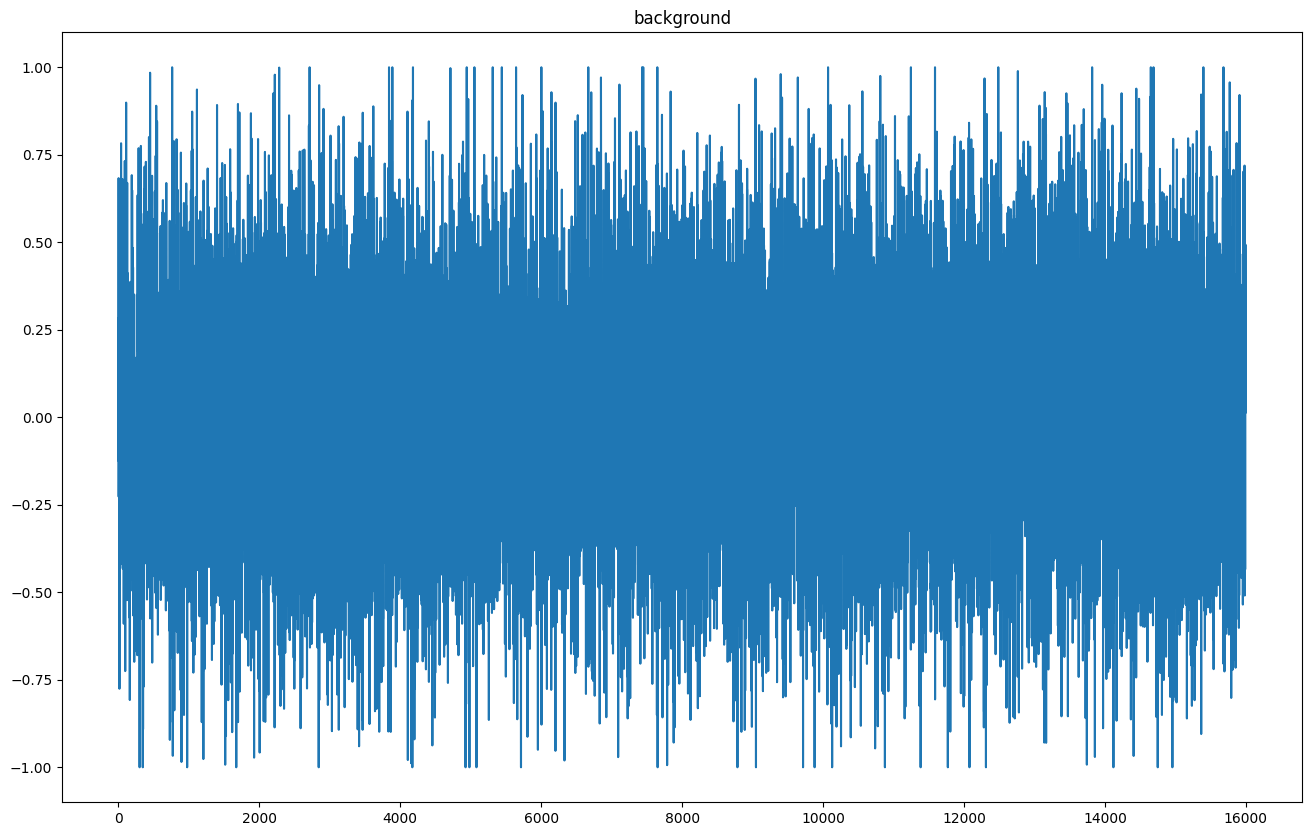

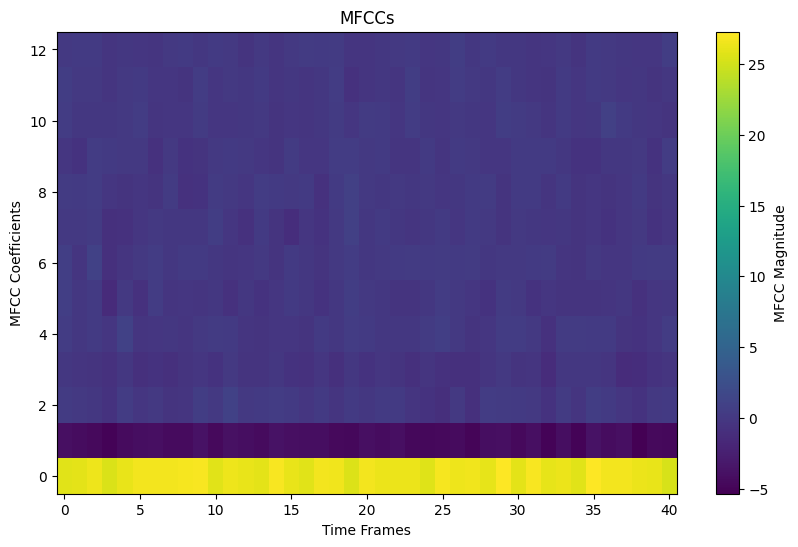

In [101]:
plt.figure(figsize=(16, 10))
plt.plot(waveform)
plt.title(label)
plot_mfccs(tf.squeeze(mfccs, axis=-1))

Create MFCC datasets from waveform datasets

In [102]:
def make_mfcc_dataset(ds):
  return ds.map(
      map_func=lambda audio,label: (generate_mfccs(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [103]:
train_mfcc_dataset = make_mfcc_dataset(train_dataset)
test_mfcc_dataset = make_mfcc_dataset(test_dataset)
validation_mfcc_dataset = make_mfcc_dataset(validation_dataset)

In [104]:
printShape(train_mfcc_dataset)
printShape(test_mfcc_dataset)
printShape(validation_mfcc_dataset)


Shape:  (32, 41, 13, 1)
Shape:  (32, 41, 13, 1)
Shape:  (32, 41, 13, 1)


TensorShape([32, 41, 13, 1])

3. **Model Definition**

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [105]:
train_mfcc_dataset = train_mfcc_dataset.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_mfcc_dataset = test_mfcc_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_mfcc_dataset = validation_mfcc_dataset.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into MFCC images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

- **tf.keras.layers.Resizing**: to downsample the input to enable the model to train faster.

- **tf.keras.layers.Normalization**: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [106]:
data_shape = printShape(train_mfcc_dataset)

input_shape = data_shape[1:]
print("Input shape: ", input_shape)

num_labels = len(label_names)
print("Number of labels: ", num_labels)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_mfcc_dataset.map(map_func=lambda spec, label: spec))

model1 = tf.keras.Sequential([
    layers.Input(shape=input_shape),    # Input layer
    #layers.Resizing(32, 32),  # Resize the input to 32x32
    #norm_layer,  # Normalize the input

    
    #layers.Conv2D(64, 3, activation='relu'),  # Convolutional Layer 1
    #layers.MaxPooling2D(pool_size=(2,2)), 

    layers.Conv2D(32, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2, padding='same'), # Max Pooling Layer
    #layers.Dropout(0.25),
    layers.Conv2D(16, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2, padding='same'), # Max Pooling Layer
    #layers.Dropout(0.25),

    layers.Flatten(),  # Flatten the data for dense layers
    layers.Dense(8, activation='relu'),  # Fully connected layer
    layers.Dropout(0.25),  # Dropout layer with 50% rate
    #layers.Dense(16, activation='relu'),  # Fully connected layer
    #layers.Dropout(0.25),  # Dropout layer with 50% rate
    layers.Dense(num_labels, 'softmax'),  # Output layer (no activation, for multi-class classification)
])
model1.summary()

#model2 = tf.keras.Sequential()
#model2.add(layers.Input(shape=input_shape))    # Input layer
#model2.add(tf.keras.layers.GaussianNoise(stddev=0.45, input_shape=(input_shape,)))
#model2.add(layers.Flatten())
#model2.add(layers.Conv1D(8, kernel_size=3, padding='same', activation='relu'))
#model2.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
#model2.add(layers.Dropout(0.25))
#model2.add(layers.Conv1D(16, kernel_size=3, padding='same', activation='relu'))
#model2.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
#model2.add(layers.Dropout(0.25))
#model2.add(layers.Flatten())
#model2.add(layers.Dense(num_labels, name='y_pred', activation='softmax'))
#
#

#model2.summary()

Shape:  (32, 41, 13, 1)
Input shape:  (41, 13, 1)
Number of labels:  4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 41, 13, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 21, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 7, 16)         4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 11, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 704)               0         
                                                 

In [107]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [108]:
history = model1.fit(
    train_mfcc_dataset,
    validation_data=validation_mfcc_dataset,
    epochs=EPOCHS ,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10, restore_best_weights=True),
)

Epoch 1/20
400/400 [==============================] - 10s 20ms/step - loss: 0.8079 - accuracy: 0.6299 - val_loss: 0.5436 - val_accuracy: 0.7715
Epoch 2/20
400/400 [==============================] - 7s 18ms/step - loss: 0.5414 - accuracy: 0.7588 - val_loss: 0.4018 - val_accuracy: 0.8606
Epoch 3/20
400/400 [==============================] - 9s 23ms/step - loss: 0.4373 - accuracy: 0.8022 - val_loss: 0.3011 - val_accuracy: 0.8970
Epoch 4/20
400/400 [==============================] - 7s 18ms/step - loss: 0.3667 - accuracy: 0.8354 - val_loss: 0.2645 - val_accuracy: 0.9046
Epoch 5/20
400/400 [==============================] - 8s 20ms/step - loss: 0.3131 - accuracy: 0.8587 - val_loss: 0.2268 - val_accuracy: 0.9203
Epoch 6/20
400/400 [==============================] - 9s 22ms/step - loss: 0.2863 - accuracy: 0.8731 - val_loss: 0.2081 - val_accuracy: 0.9259
Epoch 7/20
400/400 [==============================] - 8s 19ms/step - loss: 0.2707 - accuracy: 0.8806 - val_loss: 0.2436 - val_accuracy: 0.917

Text(0, 0.5, 'Accuracy [%]')

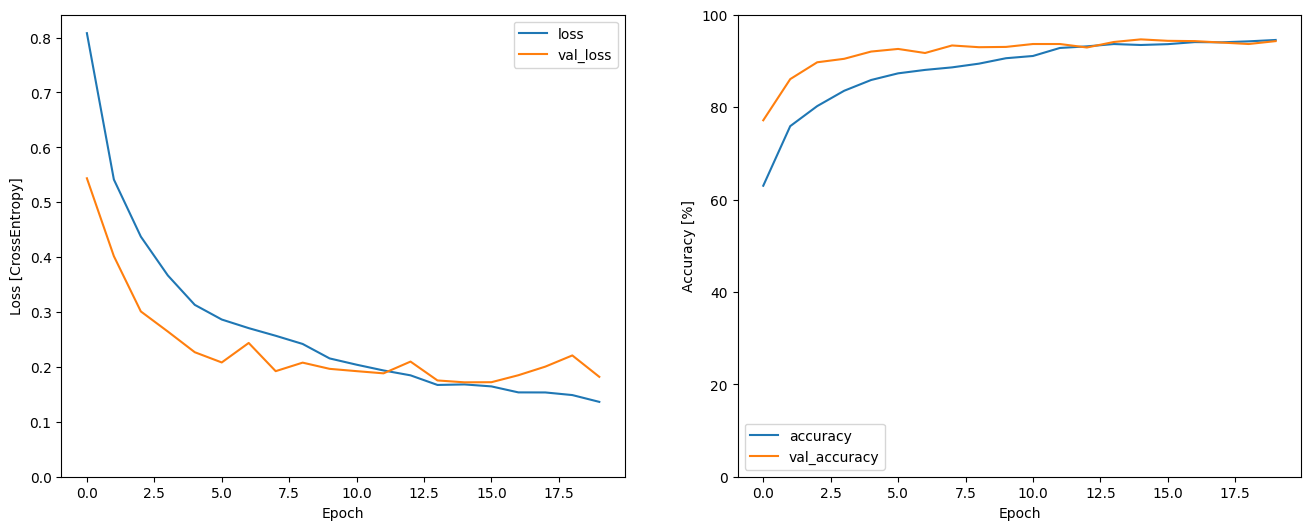

In [109]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [110]:
model1.evaluate(test_mfcc_dataset, batch_size=BATCH_SIZE, return_dict=True)

50/50 [==============================] - 6s 120ms/step - loss: 0.1590 - accuracy: 0.9550


{'loss': 0.15900945663452148, 'accuracy': 0.9549999833106995}

50/50 [==============================] - 0s 3ms/step


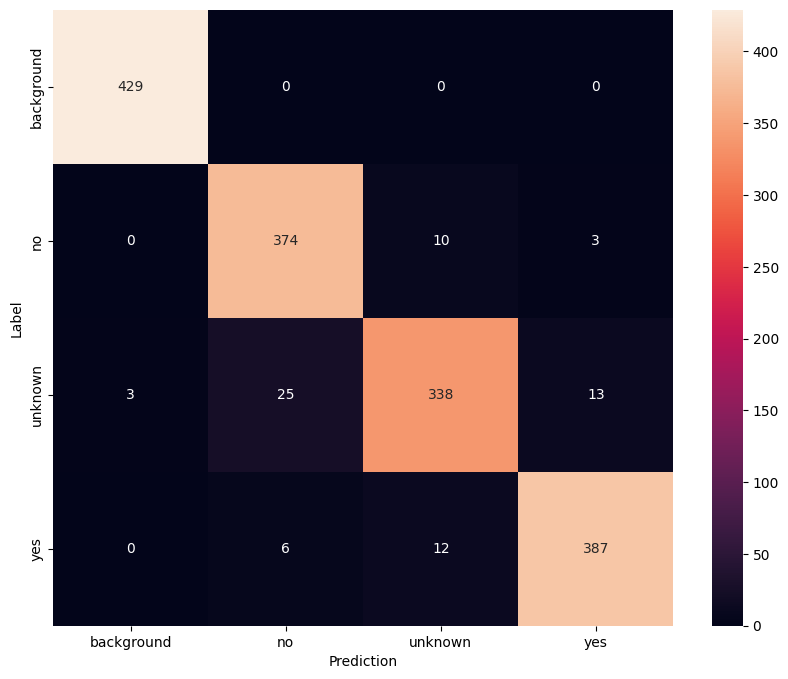

In [111]:
y_pred = model1.predict(test_mfcc_dataset)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_mfcc_dataset.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Selected files: ['commands\\background\\augmented_1300.wav', 'commands\\no\\96d8bb6f_nohash_1.wav', 'commands\\unknown\\19f9c115_nohash_0_2644.wav', 'commands\\yes\\fde2dee7_nohash_1.wav']
tf.Tensor([[9.9999821e-01 7.4528320e-20 1.6945595e-10 1.8286631e-06]], shape=(1, 4), dtype=float32)


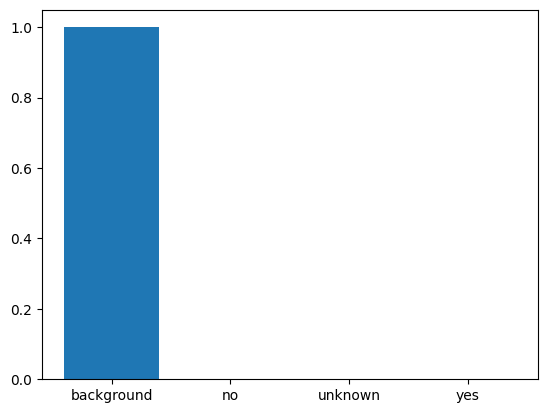

tf.Tensor([[9.2318485e-17 9.8740399e-01 1.2595986e-02 1.0369091e-10]], shape=(1, 4), dtype=float32)


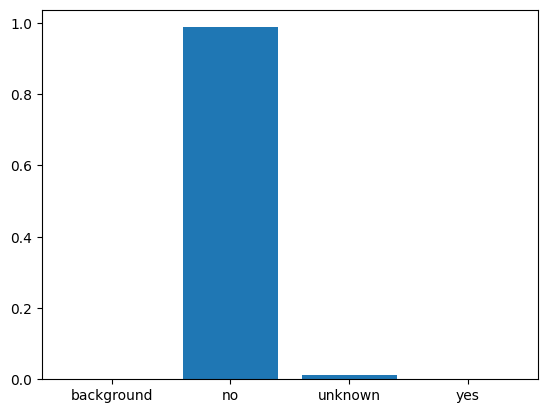

tf.Tensor([[5.6512812e-26 5.5862702e-12 1.0000000e+00 1.8073943e-12]], shape=(1, 4), dtype=float32)


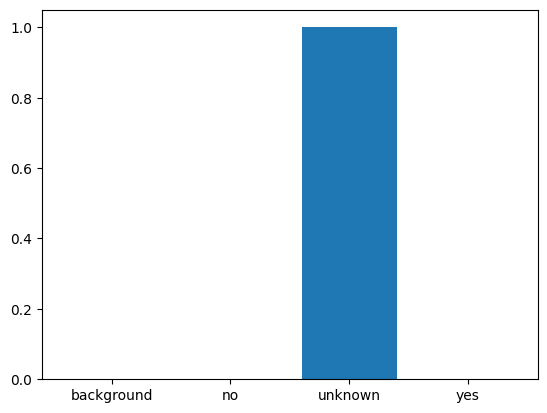

tf.Tensor([[1.4062674e-06 8.3513046e-04 1.1445486e-02 9.8771787e-01]], shape=(1, 4), dtype=float32)


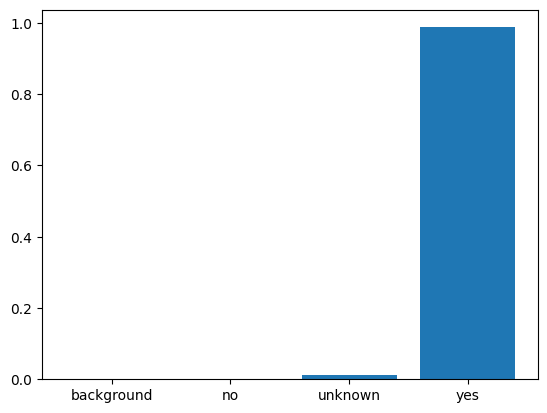

In [112]:
commands_dataset_path = "commands"
selected_files = []

# Randomly select one file from each folder
for command in commands:
    command_path = os.path.join(commands_dataset_path, command)
    if os.path.isdir(command_path):
        # Get all .wav files in the folder
        files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
        if files:  # Ensure the folder is not empty
            random_file = random.choice(files)
            selected_files.append(os.path.join(command_path, random_file))

print("Selected files:", selected_files)


# make predictions
for x in selected_files:

    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = generate_mfccs(x)
    x = x[tf.newaxis,...]
    
    prediction = model1(x)
    print(prediction)
    plt.bar(commands, prediction[0])
    #plt.title()
    plt.show()
    
    display.display(display.Audio(waveform, rate=16000))

Make models directory

In [113]:
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

NO_QUANTIZATION_MODEL = os.path.join(MODELS_DIR, 'no_quant_model.tflite')
DYNAMIC_RANGE_QUANT_MODEL = os.path.join(MODELS_DIR, 'dynamic_quant_model.tflite')
FULL_INTEGER_MODEL = os.path.join(MODELS_DIR, 'full_int_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')

Save the model

In [114]:
tf.saved_model.save(model1, MODELS_DIR)

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


Convert to TFLite without quantization

In [115]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODELS_DIR)
tflite_no_quant_model = converter.convert()

no_quant_model_size = open(NO_QUANTIZATION_MODEL, "wb").write(tflite_no_quant_model)
print("No quant model is %d bytes" % no_quant_model_size)

No quant model is 45932 bytes


Dynamic range quantization

In [116]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODELS_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

quant_model_size = open(DYNAMIC_RANGE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("Dynamic quant model is %d bytes" % quant_model_size)


Dynamic quant model is 15504 bytes


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODELS_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8

def representative_dataset():
    for audio_batch, _ in train_mfcc_dataset.take(250):  # Take a few batches for calibration
        for audio_sample in audio_batch:  # Iterate through each sample in the batch
            #mfccs = generate_mfccs(audio_sample)
            #print(audio_sample)
            audio_sample = tf.expand_dims(audio_sample, axis=0)
            yield [np.array(audio_sample, dtype=np.float32)]

converter.representative_dataset = representative_dataset
full_int_model = converter.convert()
full_int_model_size = open(FULL_INTEGER_MODEL, "wb").write(full_int_model)
print("Full integer model is %d bytes" % full_int_model_size)
interpreter = tf.lite.Interpreter(model_content=full_int_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

Full integer model is 16288 bytes
input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [118]:
def run_tflite_inference(tflite_model_path, model_type="Float"):
    # Initialize the interpreter for TensorFlow Lite
    interpreter = tf.lite.Interpreter(tflite_model_path,
                                      experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    print("Input Details:", input_details)
    print("Output Details:", output_details)

    correct_predictions = 0
    total_samples = 0

    # Iterate through the entire test dataset
    for example_mfcc, example_mfcc_labels in test_mfcc_dataset:
        # Loop over each sample in the batch
        for i in range(len(example_mfcc)):
            # Take one sample and add batch dimension
            sample = tf.expand_dims(example_mfcc[i], axis=0)
            
            # Run inference
            interpreter.set_tensor(input_details["index"], sample)
            interpreter.invoke()

            # Get the output prediction
            output = interpreter.get_tensor(output_details["index"])[0]
            top_prediction = output.argmax()

            # Print true label and predicted label for each sample
            # print("True: ", label_names[example_mfcc_labels[i]])
            # print("Predicted: ", label_names[top_prediction])

            # Update the correct predictions count
            correct_predictions += (label_names[top_prediction] == label_names[example_mfcc_labels[i]])
            total_samples += 1

    # Calculate accuracy for the entire dataset
    accuracy = (correct_predictions * 100) / total_samples
    print(f'{model_type} model accuracy is {accuracy:.2f}% (Number of test samples={total_samples})')



In [119]:
# Compute float model accuracy
run_tflite_inference(NO_QUANTIZATION_MODEL)

# Compute quantized model accuracy
run_tflite_inference(DYNAMIC_RANGE_QUANT_MODEL, model_type='Quantized')


Input Details: {'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 41, 13,  1]), 'shape_signature': array([-1, 41, 13,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Output Details: {'name': 'StatefulPartitionedCall:0', 'index': 17, 'shape': array([1, 4]), 'shape_signature': array([-1,  4]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Float model accuracy is 95.50% (Number of test samples=1600)
Input Details: {'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 41, 13,  1]), 'shape_signature': array([-1, 41, 13,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'sca

Convert to flatbuffers for microcontroller.

In [8]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {FULL_INTEGER_MODEL} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = FULL_INTEGER_MODEL.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x80, 0x00, 0x00, 0x00, 0xd8, 0x00, 0x00, 0x00, 0x88, 0x2c, 0x00, 0x00,
  0x98, 0x2c, 0x00, 0x00, 0xcc, 0x3e, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x46, 0xd2, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x